<a href="https://colab.research.google.com/github/LuAsm/simple_python_project/blob/master/Copy_of_Project_1_CNN_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/aurimas13/CodeAcademy-AI-Course/blob/main/Projects/Project_1_CNN_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Imports

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms

from torch.utils.data import Dataset
import requests
import torchvision.datasets as datasets
from time import time



from typing import Tuple, List

from sklearn.model_selection import train_test_split

# <b>Loading Data

In [4]:

#download and load dataset to train and test
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# <b> Device



In [33]:
import torch
# choose to train model on GPU otherwise on CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# <b> Hyperparameters

In [6]:

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
# Choose the total number of iteration
epochs = 5

# <b> Neural Network Architecture

In [7]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    # Convolutional Neural Network layer
    self.convolutional_neural_network_layers = nn.Sequential(
        # We caclute the output of each covoluion layer using the formula:
        # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1),  # (N, 1, 28, 28)
        nn.ReLU(),
        # After the first convolutional layer the output of this layer is:
        # [(28 + 2*1 - 3) /1] + 1 = 28
        nn.MaxPool2d(kernel_size=2),
        # Since we applied maxxpooling with kernel_size =2 we have to divide by 2 and we get:
        # 28 / 2 = 14
        # Output of our second convultion layer
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        # After the second convolutional layer output of our second convultion layer the output of this layer will be:
        # [(14 + 2*1 - 3/1)] + 1  = 14
        nn.MaxPool2d(kernel_size=2)
        # Since we applined maxpooling with kernel_size=2 we have divide by 2 and we get then:
        # 14 / 2 = 7
    )

    # Linear Layer
    self.linear_layers = nn.Sequential(
        # We have the output channels of 24 of our second convolutional and 7*7 from formula
        # which give us the output of each convolutional layer
        nn.Linear(in_features=24*7*7, out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=64, out_features=10)
    )

  # Defining forward pass
  def forward(self, x):
    x = self.convolutional_neural_network_layers(x)
    # After we get output of our convolutional layer we must flatten it 
    x = x.view(x.size(0), -1)
    # Then pass it through the linear layer
    x = self.linear_layers(x)
    # The softmax function returns the prob likelihood of getting the input image.
    # We will see a graphical demonstration below
    x = F.log_softmax(x, dim=1)
    return x

# <b> Initialization

In [8]:
# define model to our network
model = Network()
# load model to device
model.to(device)
print(model)

Network(
  (convolutional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


# <b> Loss & Optimizer

In [9]:
from torch import optim

In [10]:
#define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
#define loss
criterion = nn.CrossEntropyLoss()

# <b> Prepare Data

In [11]:
#create empty list for train and test 
train_losses = []
test_losses = []

# <b> Train Neural Network

In [12]:
for epoch in range(epochs):
  # model for training
  model.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(trainloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = model(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    model.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in testloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = model(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_losses.append(train_loss/len(trainloader))
      test_losses.append(test_loss/len(trainloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(trainloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(trainloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(testloader)))

Epoch: 1/5    Training loss: 1.2427    Testing loss: 0.0642    Test accuracy: 0.8851   
Epoch: 2/5    Training loss: 0.3714    Testing loss: 0.0401    Test accuracy: 0.9299   
Epoch: 3/5    Training loss: 0.2799    Testing loss: 0.0329    Test accuracy: 0.9386   
Epoch: 4/5    Training loss: 0.2263    Testing loss: 0.0249    Test accuracy: 0.9540   
Epoch: 5/5    Training loss: 0.1949    Testing loss: 0.0212    Test accuracy: 0.9611   


# <b> Check metrics & test neural network


# <b> Prediction (Visual or Written)

In [34]:
#choose which img we predict
img = images[2]
print(img.shape)
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Sice we want to use already pretrained wieghts to make some predicition
# we are turing of gradients
with torch.no_grad():
  logits = model.forward(img)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [14]:
from matplotlib import pyplot as plt
import numpy as np

[7.67320398e-06 3.33254757e-05 3.21312575e-03 1.73268523e-02
 5.56397426e-04 1.01135531e-03 3.68196083e-07 1.16544186e-04
 9.45308924e-01 3.24255116e-02]


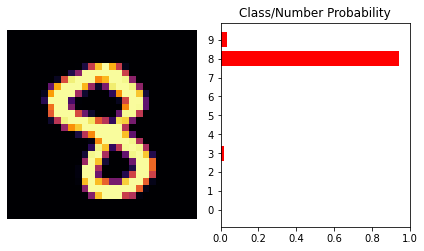

In [29]:
#show prob as img
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_xlim(0, 1)
ax2.set_title('Class/Number Probability')

plt.tight_layout()

In [30]:
#print prob as text 
print(np.argmax(probabilities))

8
